# Setup

**Imports**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

**Utility functions**

In [3]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

In [8]:
# This is an example of plot (random data). You can change it if you want.

## Change the following lines
# periodograms = np.random.randn(100, 200)  # shape (n_trials, n_freqs)
# freqs = np.linspace(0, 0.5, 200)
##

def plot_signal_average_and_std(freqs, periodograms, xlabel='', ylabel=''):
    
    fig, ax = fig_ax(figsize=(9, 5))

    avg = periodograms.mean(axis=0)
    std = periodograms.std(axis=0)
    ax.plot(freqs, avg, 'k-')
    ax.fill_between(freqs, avg-std, avg+std, alpha=0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


In [5]:
from statsmodels.tsa.stattools import acovf
from scipy.signal import periodogram

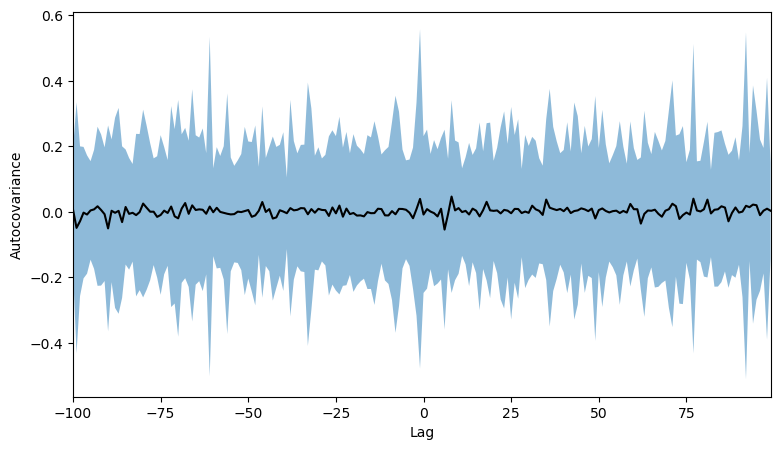

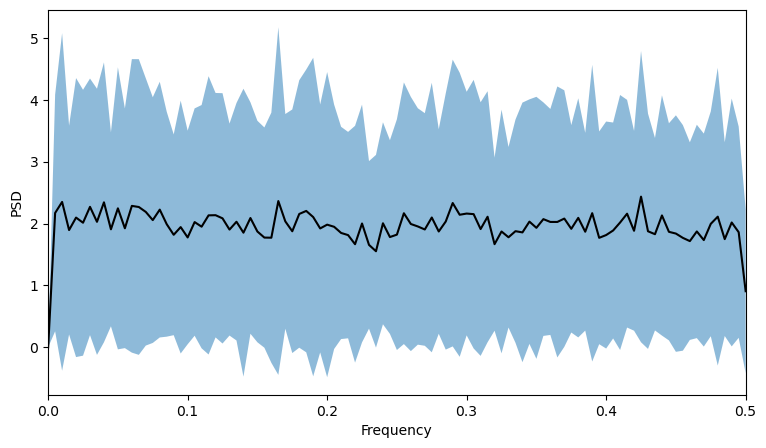

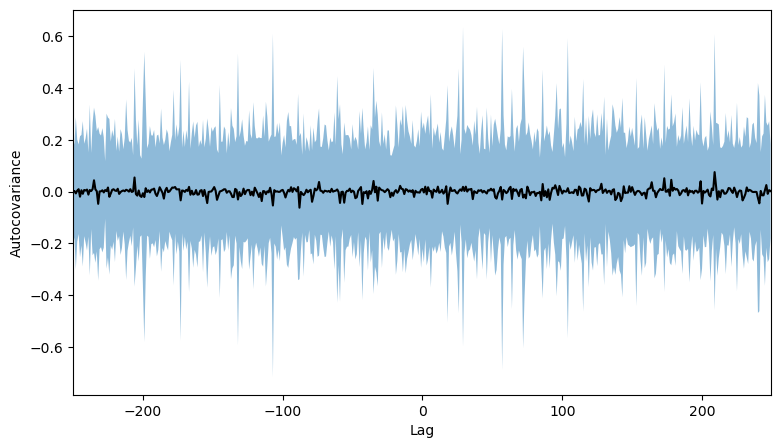

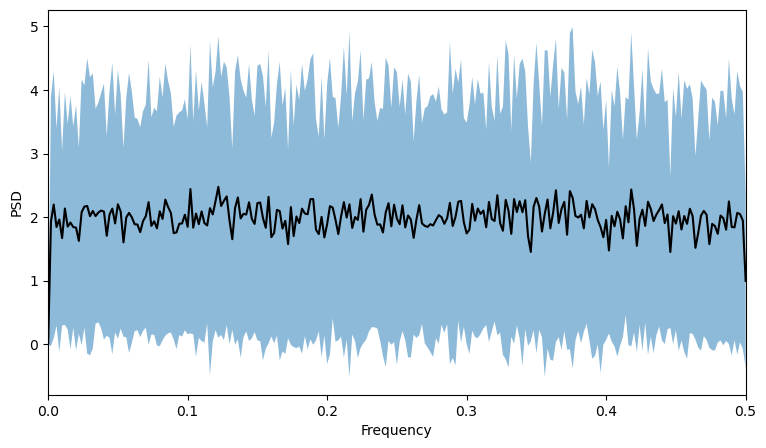

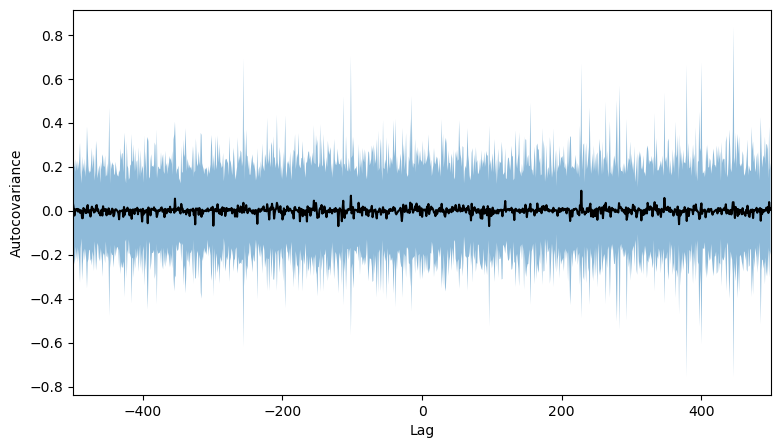

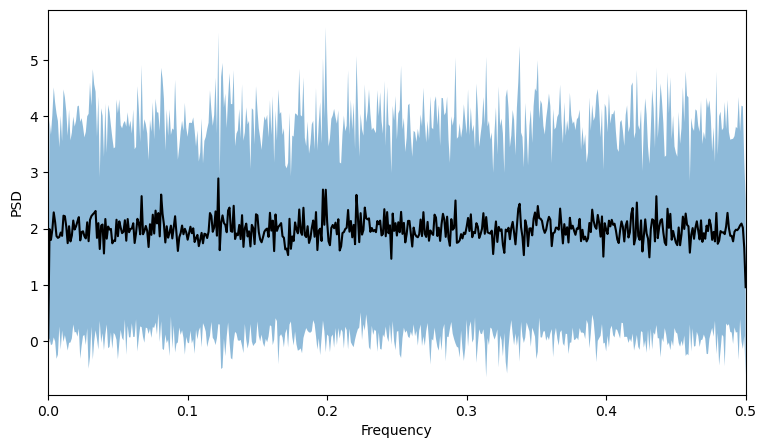

In [11]:
list_N = (200, 500, 1000)
number_of_simulations = 100



for N in list_N:
    signal = np.random.randn(number_of_simulations, N)
    
    # sample autocovariances
    lags = list(range(-N//2, N//2))
    autocovariances = np.apply_along_axis(acovf, 0, signal, adjusted=True, fft=False)
    plot_signal_average_and_std(lags, autocovariances, xlabel='Lag', ylabel='Autocovariance')
    
    
    # Periodogram 
    freqs, periodograms = periodogram(signal, fs=1) 
    plot_signal_average_and_std(freqs, periodograms, xlabel='Frequency', ylabel='PSD')

## Question 9

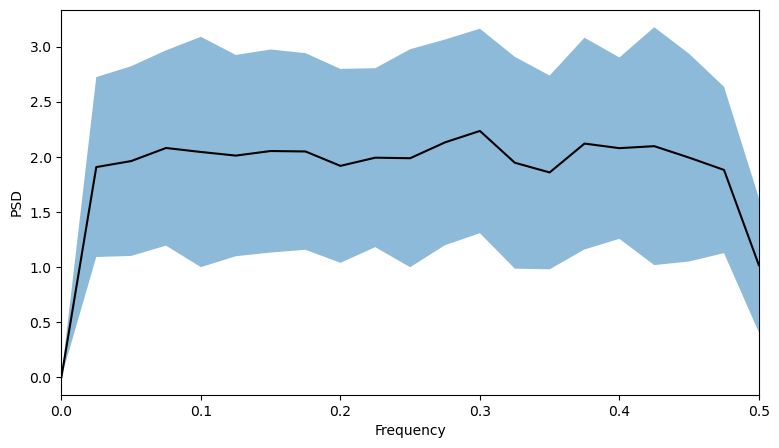

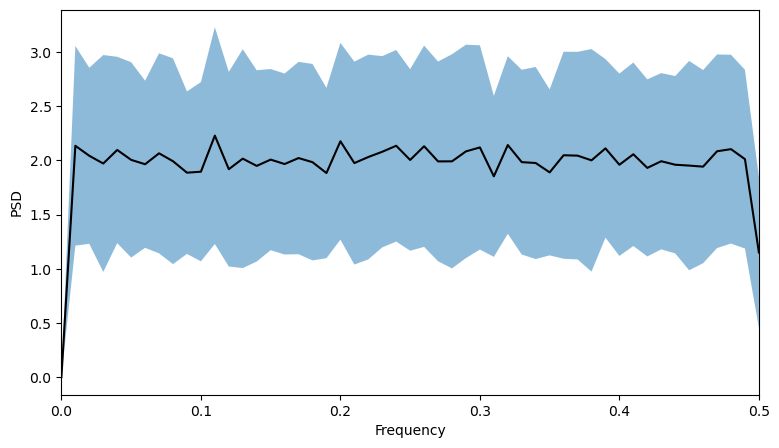

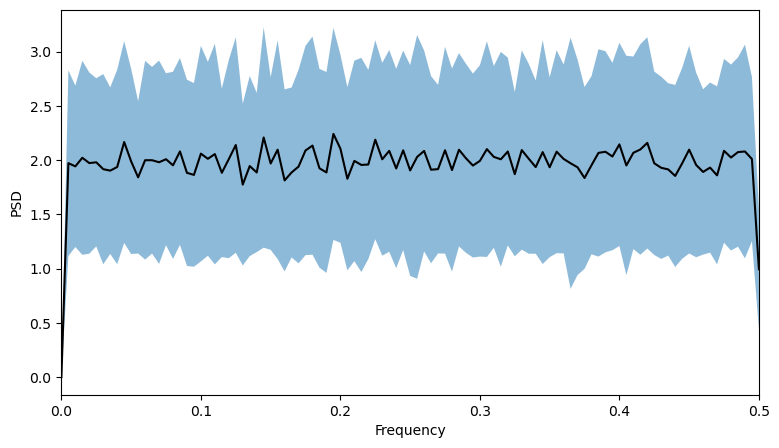

In [12]:
# Barlett's estimate

K = 5

for N in list_N:
    signal = np.random.randn(number_of_simulations, N)
    length = N // K
    sections = np.stack([ signal[:, i*length : (i+1)*length ] for i in range(K) ], axis=2)
    freqs, periodograms = periodogram(sections, fs=1, axis=1) 
    bartlett_estimates = periodograms.mean(axis=-1)
    plot_signal_average_and_std(freqs, bartlett_estimates, xlabel='Frequency', ylabel='PSD')

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [18]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

## Question 10

In [28]:
from tslearn.utils import to_time_series_dataset
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [25]:
# Preprocess data

X_train = to_time_series_dataset(X_train)
X_test  = to_time_series_dataset(X_test)

# Search for the best k

clf = GridSearchCV (
    estimator  = KNeighborsTimeSeriesClassifier(metric='dtw', n_jobs=-1),
    param_grid = { 'n_neighbors': list(range(2, 50)) },
    scoring    = 'f1',
    n_jobs     = -1,
    cv         = 5
)

clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsTimeSeriesClassifier(n_jobs=-1),
             n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                         24, 25, 26, 27, 28, 29, 30, 31, ...]},
             scoring='f1')

In [32]:
test_pred = clf.predict(X_test)

In [34]:
best_k        = clf.best_estimator_.n_neighbors

f1_validation = clf.best_score_
f1_test       = f1_score(y_test, test_pred)

print(f"Best number of neighbors: {best_k}")
print(f"F1 score (Validation) :\t{f1_validation}" )
print(f"F1 score (Test) :\t{f1_test}" )

Best number of neighbors: 5
F1 score (Validation) :	0.781814185073362
F1 score (Test) :	0.5132743362831859


## Question 11

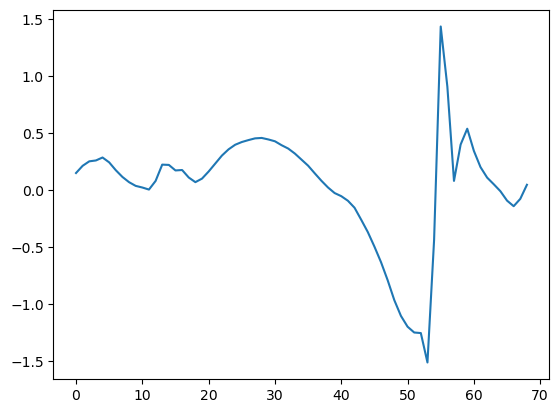

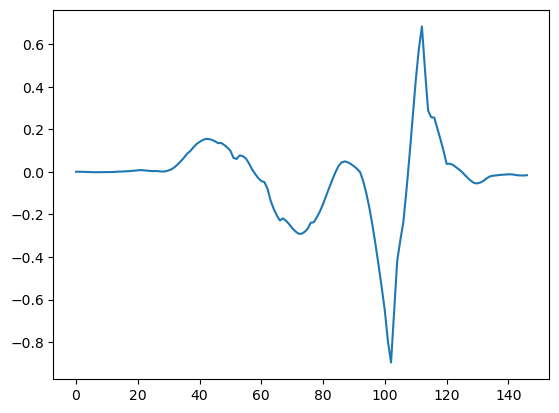

In [63]:
# Healthy predicted non-healthy
plt.plot(X_test[np.logical_and(np.array(y_test) == 0, np.array(test_pred) == 1).argmax()]); plt.figure()

# Non-healthy predicted healthy
plt.plot(X_test[np.logical_and(np.array(y_test) == 1, np.array(test_pred) == 0).argmax()])